In [1]:
from uuid import uuid4

rand_token = uuid4()
str(rand_token)

'ba4f817c-96b6-4a1c-93ca-c60d65ab2b87'

In [2]:
import numpy as np
import pandas as pd
import urllib.request
import math
import statistics
from scipy import stats

In [3]:
def report(df,place=0):
    column_names = df.columns.to_list()
    row = df.iloc[place]
    for i in range(0,len(column_names)):
        print(column_names[i],':',row[i])

#### Загрузка таблицы

In [4]:
params_part = True
url = 'https://service.icecorp.ru/log_ttl_data/data_8789cb34-7f28-4965-b0df-097ee9a24f71.csv'

with urllib.request.urlopen(url) as response:
    lines = response.readlines()
    with open('params.csv', 'wb') as params_file:
        with open('data.csv', 'wb') as data_file:
            for line in lines:
                if line==b'id;date;phone;ttl;AppVersion;osversion;devicename;Backend\n':
                    params_part = False
                if params_part:
                    params_file.write(line)
                else:        
                    data_file.write(line)
        data_file.close()
    params_file.close()
params = pd.read_csv("params.csv",';')
df = pd.read_csv("data.csv",';')
df.fillna(0, inplace=True)

In [5]:
params

,send_report,title,date
0,0,"Srvr=""srv1c01"" Ref=""1c_service""",01.09.2020 10:09:52


In [68]:
#params.iloc()[0].send_report

In [69]:
#url = 'https://service.icecorp.ru/log_ttl_data/data.csv'
#with urllib.request.urlopen(url) as response, open('data.csv', 'wb') as out_file:
#    data = response.read() # a `bytes` object
#    out_file.write(data)

In [70]:
#df = pd.read_csv("data.csv",';')
#df.fillna(0, inplace=True)

In [71]:
#df[]

In [6]:
report(df)

id : 15 498 602
date : 25.08.2020 0:00:07
phone : 1835
ttl : bidinfo*a1598302806719b1598302806947c1598302806947d1598313606117e1598313606617f1598302807555g1598302807555h1598302807548i1598302807553j1598313606867
AppVersion : 597
osversion : 7.1.1
devicename : Sony E6683 E6683
Backend : https://mpk.iceberg.ru:61443/MasterService/


In [73]:
# Отбор по мастеру
#df = df[df.phone==497]

#### Определим время жизни пакетов

In [7]:
def get_len(last_string):
    try:
        splitters = ['*','a','b','c','d','e','f','g','h','i','j']
        ttl = []
        for splitter in splitters:
            new_string = last_string.split(splitter)
            last_string = new_string[1]
            ttl.append(new_string[0])
        ttl.append(last_string)
        first_value = int(ttl[2])
        last_value = int(ttl[-2:][0])
        return last_value-first_value
    except Exception as e:
        return 0
    

df['dev_len']=df['ttl'].apply(get_len)

report(df)

id : 15 498 602
date : 25.08.2020 0:00:07
phone : 1835
ttl : bidinfo*a1598302806719b1598302806947c1598302806947d1598313606117e1598313606617f1598302807555g1598302807555h1598302807548i1598302807553j1598313606867
AppVersion : 597
osversion : 7.1.1
devicename : Sony E6683 E6683
Backend : https://mpk.iceberg.ru:61443/MasterService/
dev_len : 834


#### Выделим функцию

In [8]:
def get_func(last_string):
    return last_string.split('*')[0]
df['func']=df['ttl'].apply(get_func)

report(df)

id : 15 498 602
date : 25.08.2020 0:00:07
phone : 1835
ttl : bidinfo*a1598302806719b1598302806947c1598302806947d1598313606117e1598313606617f1598302807555g1598302807555h1598302807548i1598302807553j1598313606867
AppVersion : 597
osversion : 7.1.1
devicename : Sony E6683 E6683
Backend : https://mpk.iceberg.ru:61443/MasterService/
dev_len : 834
func : bidinfo


#### Заполним таймеры этапов

In [9]:
def get_timers(last_string,step):
    try:
        splitters = ['*','a','b','c','d','e','f','g','h','i','j']
        ttl = []
        for splitter in splitters:
            new_string = last_string.split(splitter)
            last_string = new_string[1]
            ttl.append(new_string[0])
        ttl.append(last_string)    
        return int(ttl[step])/1000
    except Exception as e:
        return 0

timer_columns = ['a','b','c','d','e','f','g','h','i','j']
for i in range(0,len(timer_columns)):
    column_name = timer_columns[i]
    df[column_name]=df['ttl'].apply(get_timers,step=i+2)

report(df)

id : 15 498 602
date : 25.08.2020 0:00:07
phone : 1835
ttl : bidinfo*a1598302806719b1598302806947c1598302806947d1598313606117e1598313606617f1598302807555g1598302807555h1598302807548i1598302807553j1598313606867
AppVersion : 597
osversion : 7.1.1
devicename : Sony E6683 E6683
Backend : https://mpk.iceberg.ru:61443/MasterService/
dev_len : 834
func : bidinfo
a : 1598302806.719
b : 1598302806.947
c : 1598302806.947
d : 1598313606.117
e : 1598313606.617
f : 1598302807.555
g : 1598302807.555
h : 1598302807.548
i : 1598302807.553
j : 1598313606.867


#### Определим смещение по записи с минимальной длительностью в мс для каждого номера телефона

In [10]:
#phone=497
#mask = ( df['phone'] == phone) & (df['Backend']=='https://mpk.iceberg.ru:61443/MasterService/')
#df[mask].Backend.unique()

In [11]:
'''phone = 497
for backend in df[df['phone'] == phone].Backend.unique():
    mask = ( df['phone'] == phone) & (df['Backend']==backend)
    mr = df[mask].sort_values(by=['dev_len']).iloc[0]
    print(backend,mr.bias_top,mr.bias_bottom)
    '''

"phone = 497\nfor backend in df[df['phone'] == phone].Backend.unique():\n    mask = ( df['phone'] == phone) & (df['Backend']==backend)\n    mr = df[mask].sort_values(by=['dev_len']).iloc[0]\n    print(backend,mr.bias_top,mr.bias_bottom)\n    "

In [12]:
for phone in df["phone"].unique():
    for backend in df[df['phone'] == phone].Backend.unique():
        mask = ( df['phone'] == phone) & (df['Backend']==backend)
        #sel = df[df.phone==phone]
        #sel = sel[sel.dev_len!=0]
        #sel = df[mask]
        mr = df[mask].sort_values(by=['dev_len']).iloc[0] #minimal delay record
        #mr = sel[sel.phone==phone].sort_values(by=['dev_len']).iloc[0] #minimal delay record
        #mr = df[df.phone==phone].sort_values(by=['dev_len']).iloc[0] #minimal delay record
        #print(backend,mr)
        bias_top=(mr.h-mr.a-(mr.g-mr.b))/2-(mr.b-mr.a)
        bias_bottom=(mr.f+bias_top-(mr.c+bias_top)-(mr.e-mr.d))/2-(mr.d-(mr.c+bias_top))
        #print(bias_top,bias_bottom)
        #break
        df.loc[mask, 'bias_top'] = bias_top
        df.loc[mask, 'bias_bottom'] = bias_bottom

for phone in df["phone"].unique():
    
    sel = df[df.phone==phone]
    sel = sel[sel.dev_len!=0]
    
    mr = sel[sel.phone==phone].sort_values(by=['dev_len']).iloc[0] #minimal delay record
    #mr = df[df.phone==phone].sort_values(by=['dev_len']).iloc[0] #minimal delay record
    
    bias_top=(mr.h-mr.a-(mr.g-mr.b))/2-(mr.b-mr.a)
    bias_bottom=(mr.f+bias_top-(mr.c+bias_top)-(mr.e-mr.d))/2-(mr.d-(mr.c+bias_top))
    df.loc[df['phone'] == phone, 'bias_top'] = bias_top
    df.loc[df['phone'] == phone, 'bias_bottom'] = bias_bottom

#### Вычислим время между инстанциями

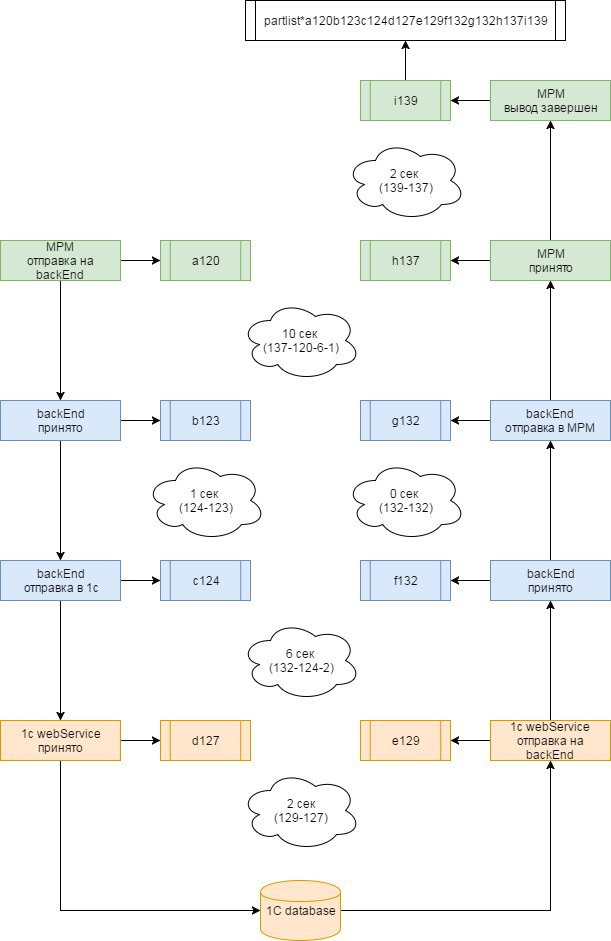

In [13]:
df['ab_mrm_to_back']      = df.b - df.a + df.bias_top    
df['bc_back_to_back']     = df.c - df.b
df['cd_back_to_1c']       = df.d - df.c + df.bias_bottom - df.bias_top
df['de_1c_to_1c']         = df.e - df.d
df['ef_1c_to_back']       = df.f - df.e + df.bias_top - df.bias_bottom
df['fg_back_to_back']     = df.g - df.f
df['gh_back_to_mrm']      = df.h - df.g - df.bias_top
df['hi_mrm_to_mrm']       = df.i - df.h

In [14]:
df['full_len']=df['ab_mrm_to_back']+df['bc_back_to_back']+df['cd_back_to_1c']+df['de_1c_to_1c']+df['ef_1c_to_back']+df['fg_back_to_back']+df['gh_back_to_mrm']+df['hi_mrm_to_mrm']
report(df,0)

id : 15 498 602
date : 25.08.2020 0:00:07
phone : 1835
ttl : bidinfo*a1598302806719b1598302806947c1598302806947d1598313606117e1598313606617f1598302807555g1598302807555h1598302807548i1598302807553j1598313606867
AppVersion : 597
osversion : 7.1.1
devicename : Sony E6683 E6683
Backend : https://mpk.iceberg.ru:61443/MasterService/
dev_len : 834
func : bidinfo
a : 1598302806.719
b : 1598302806.947
c : 1598302806.947
d : 1598313606.117
e : 1598313606.617
f : 1598302807.555
g : 1598302807.555
h : 1598302807.548
i : 1598302807.553
j : 1598313606.867
bias_top : -15.508999943733215
bias_bottom : -10814.62950015068
ab_mrm_to_back : -15.281000018119812
bc_back_to_back : 0.0
cd_back_to_1c : 0.04949986934661865
de_1c_to_1c : 0.5
ef_1c_to_back : 0.05850017070770264
fg_back_to_back : 0.0
gh_back_to_mrm : 15.501999974250793
hi_mrm_to_mrm : 0.004999876022338867
full_len : 0.8339998722076416


In [15]:
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

max(df[np.abs(df.ef_1c_to_back-df.ef_1c_to_back.mean()) <= (3*df.ef_1c_to_back.std())].ef_1c_to_back)
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

#min(df['ef_1c_to_back'])

20.92200005054474

#### График по операторам

In [83]:
def plot_operators(df):
    
    df['oper']=(df.phone/10000000).apply(int)
    df.oper.unique()
    
    # mrm to backend
    graphic = df[df.func=='bidphotoadd'].groupby('oper').median().sort_values('ab_mrm_to_back').plot(
        y=['ab_mrm_to_back'],
        kind='bar',
        title = 'bidphotoadd',
        figsize=(15,4)
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
    
    # backend to mrm
    graphic = df[df.func=='bidinfo'].groupby('oper').median().sort_values('gh_back_to_mrm').plot(
        y=['gh_back_to_mrm'],
        kind='bar',
        title = 'bidinfo',
        figsize=(15,4)
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
    
#plot_operators(df)

#### График по устройствам

In [84]:
def plot_versions(df,func):
    #for func in df['func'].unique():
    sel = df[df.func==func].groupby('devicename').median().sort_values('ab_mrm_to_back')
    #graphic = df[df.func==func].groupby('devicename').median().sort_values('ab_mrm_to_back').plot(
    #graphic = sel[sel.ab_mrm_to_back>2].plot(
    graphic = sel.plot(
        y=[
            'ab_mrm_to_back',
            #'gh_back_to_mrm',
            #'hi_mrm_to_mrm'
        ],
        kind='bar',
        title = func,
        #subplots=True,
        figsize=(30,10),
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")

#plot_versions(df,'bidphotoadd')
#plot_versions(df,'bidlist')
#plot_versions(df,'bidinfo')

#### График по версиям ОС

In [85]:
def plot_versions(df,func):
    #for func in df['func'].unique():
    graphic = df[df.func==func].groupby('osversion').median().plot(
        y=[
            'ab_mrm_to_back',
            'gh_back_to_mrm',
            'hi_mrm_to_mrm'
        ],
        kind='bar',
        title = func,
        #subplots=True,
        figsize=(15,6),
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")

#plot_versions(df,'bidphotoadd')
#plot_versions(df,'bidlist')
#plot_versions(df,'bidinfo')

#### График по версиям приложения

In [86]:
def plot_versions(df,func):
    #for func in df['func'].unique():
    graphic = df[df.func==func].groupby('AppVersion').median().plot(
        y=[
            'ab_mrm_to_back',
            'gh_back_to_mrm',
            'hi_mrm_to_mrm'
        ],
        kind='barh',
        title = func,
        #subplots=True,
        figsize=(15,6),
        grid=True
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")

#plot_versions(df,'bidphotoadd')
#plot_versions(df,'bidlist')
#plot_versions(df,'bidinfo')

#### Относительное кол-во длительный запросов

In [87]:
def long_query():
    treshold = 4
    mask = ( df['func'] == 'bidlist') & (df['full_len']>treshold)
    print('Всего записей:',len(df))
    print('Превышают',treshold,"сек.:",len(df[mask]))
    print('Или',math.ceil(len(df[mask])/len(df)*100),"%")
#long_query()

#### Топ длительных запросов

In [88]:
def top_longest():
    #df[df.func=='bidlist'].sort_values('dev_len',ascending=False).head(12).date
    #len(df[df.func=='bidlist'].sort_values('dev_len',ascending=False).head(33).groupby('date').max())
    #df[df.func=='bidlist'].dev_len.median()
    func = 'bidlist'
    sel = df[df.func==func].sort_values('dev_len',ascending=False).head(33).groupby('date').max().sort_values('dev_len',ascending=True)
    #sel.drop(['id','phone','ttl'], axis=1, inplace=True)
    sel[[
        #   'date',
        'dev_len',
        'ab_mrm_to_back',
        'bc_back_to_back',
        'cd_back_to_1c',
        'de_1c_to_1c',
        'ef_1c_to_back',
        'fg_back_to_back',
        'gh_back_to_mrm',
        'hi_mrm_to_mrm',
    ]].to_excel("output.xlsx")  
#top_longest()

#### Самые длительные запросы

In [89]:
report(df[df.func=='bidlist'].sort_values('dev_len',ascending=False).head(1))

id : 15 496 619
date : 24.08.2020 18:51:50
phone : 1310
ttl : bidlist*a1598284132894b1598284302440c1598284302440d1598295101606e1598295103841f1598284304796g1598284304796h1598284308883i1598284308919j1598295110278
AppVersion : 580
osversion : 10
devicename : HMD Global Plate2_00WW Nokia 6.1
Backend : https://mpk.iceberg.ru:61443/MasterService/
dev_len : 176025
func : bidlist
a : 1598284132.894
b : 1598284302.44
c : 1598284302.44
d : 1598295101.606
e : 1598295103.841
f : 1598284304.796
g : 1598284304.796
h : 1598284308.883
i : 1598284308.919
j : 1598295110.278
bias_top : -1.584999918937683
bias_bottom : -10800.681999921799
ab_mrm_to_back : 167.961000084877
bc_back_to_back : 0.0
cd_back_to_1c : 0.06899988651275635
de_1c_to_1c : 2.2350001335144043
ef_1c_to_back : 0.05199992656707764
fg_back_to_back : 0.0
gh_back_to_mrm : 5.67199981212616
hi_mrm_to_mrm : 0.03600001335144043
full_len : 176.02499985694885


In [90]:
def plot_longest(df):
    func = 'bidlist'
    #df[df.func==func].sort_values('dev_len',ascending=False).head(20)
    #df['day'] = df['date'].str.split().str[0]
    
    #for func in df['func'].unique():
    #graphic = df[df.func==func].groupby('AppVersion').median().plot(
    #graphic = df.groupby('day').median().plot(        
    #graphic = df[df.func==func].groupby('day').median().plot(
    graphic = df[df.func==func].sort_values('dev_len',ascending=False).head(10).groupby('date').max().sort_values('dev_len',ascending=True).plot(        
        y=[
            'ab_mrm_to_back',
            'bc_back_to_back',
            'cd_back_to_1c',
            'de_1c_to_1c',
            'ef_1c_to_back',
            'fg_back_to_back',
            'gh_back_to_mrm',
            'hi_mrm_to_mrm',
            'full_len'
        ],
        kind='barh',
        title = func,
        #subplots=True,
        figsize=(15,15),
        grid=True
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
#plot_longest(df)

#### График по бэкендам

In [91]:
def plot_backends(df):
    
    #df['day'] = df['date'].str.split().str[0]
    #func = 'bidlist'
    #for func in df['func'].unique():
    #graphic = df[df.func==func].groupby('AppVersion').median().plot(
    #graphic = df.groupby('day').median().plot(        
    #graphic = df[df.func==func].groupby('Backend').median().plot(
    graphic = df.groupby('Backend').median().plot(
        y=[
            'ab_mrm_to_back',
            'bc_back_to_back',
            'cd_back_to_1c',
            #'de_1c_to_1c',
            'ef_1c_to_back',
            'fg_back_to_back',
            'gh_back_to_mrm',
            #'hi_mrm_to_mrm',
            'full_len'
        ],
        kind='barh',
        #title = func,
        #subplots=True,
        figsize=(15,6),
        grid=True
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
#plot_backends(df)

#### Исключим выбросы

In [16]:
df_b = df
time_fields = [
    'ab_mrm_to_back',
    'bc_back_to_back',
    'cd_back_to_1c',
    'de_1c_to_1c',
    'ef_1c_to_back',
    'fg_back_to_back',
    'gh_back_to_mrm',
    'hi_mrm_to_mrm'
]
for field in time_fields:
    df_b = df_b[np.abs(df_b[field]-df_b[field].mean()) <= (2.1*df_b[field].std())]

In [93]:
min(df_b['ef_1c_to_back'])

-0.021000146865844727

In [94]:
#min(df[np.abs(df[field]-df[field].mean()) <= (3*df[field].std())]['ef_1c_to_back'])

In [19]:
df.func.unique()

array(['bidinfo', 'bidlist', 'lockbidlist', 'bidphotoadd', 'partlist',
       'masterlist', 'nulli1598334710137j1598345510356',
       'masterorderlist', 'nulli1598424839812j1598435639930',
       'nulli1598446888102j1598457679045',
       'nulli1598547698589j1598558499023'], dtype=object)

#### Количество обращений всего

In [25]:
func = 'bidlist'
df['day'] = df['date'].str.split().str[0]
df[df.func==func].groupby('day').mean()

,phone,AppVersion,dev_len,a,b,c,d,e,f,g,...,bias_bottom,ab_mrm_to_back,bc_back_to_back,cd_back_to_1c,de_1c_to_1c,ef_1c_to_back,fg_back_to_back,gh_back_to_mrm,hi_mrm_to_mrm,full_len
day,,,,,,,,,,,,,,,,,,,,,
25.08.2020,1112.077670,595.688438,4063.876686,1.598351e+09,1.598351e+09,1.598351e+09,1.598362e+09,1.598362e+09,1.598351e+09,1.598351e+09,...,-9054.673533,-0.325787,0.000006,1734.827804,2.717234,-1734.625908,0.000532,1.400004,0.069992,4.063877
26.08.2020,1156.582552,595.748509,4177.119408,1.598437e+09,1.598437e+09,1.598437e+09,1.598448e+09,1.598448e+09,1.598437e+09,1.598437e+09,...,-9107.092180,-0.865724,0.000008,1681.883713,2.470084,-1681.665205,0.000530,2.281571,0.072142,4.177119
27.08.2020,1158.548543,595.732393,3968.570495,1.598524e+09,1.598524e+09,1.598524e+09,1.598535e+09,1.598535e+09,1.598524e+09,1.598524e+09,...,-9420.622172,-1.460544,0.000008,1370.256909,2.556160,-1370.088173,0.000469,2.633971,0.069770,3.968570
28.08.2020,1203.757368,597.042928,3817.351231,1.598611e+09,1.598611e+09,1.598611e+09,1.598621e+09,1.598621e+09,1.598611e+09,1.598611e+09,...,-9134.845148,-1.071169,0.000008,1653.896161,2.506695,-1653.712588,0.000539,2.129549,0.068156,3.817351
29.08.2020,1219.333591,597.162705,3809.953844,1.598697e+09,1.598697e+09,1.598697e+09,1.598708e+09,1.598708e+09,1.598697e+09,1.598697e+09,...,-9196.228026,-1.309575,0.000012,1593.786207,2.385539,-1593.600989,0.000437,2.482120,0.066203,3.809954
30.08.2020,1131.785587,597.251822,3714.616680,1.598784e+09,1.598784e+09,1.598784e+09,1.598795e+09,1.598795e+09,1.598784e+09,1.598784e+09,...,-9415.739794,-0.373169,0.000003,1379.916631,2.361280,-1379.750098,0.000599,1.491770,0.067601,3.714617
31.08.2020,1110.654318,597.372036,3904.036727,1.598869e+09,1.598869e+09,1.598869e+09,1.598880e+09,1.598880e+09,1.598869e+09,1.598869e+09,...,-9428.557226,-1.636682,0.000007,1364.851653,2.556655,-1364.663976,0.000536,2.731279,0.064566,3.904037


In [50]:
df_f = df.groupby(['func', 'day']).count().id

In [57]:
df_f

func                              day       
bidinfo                           25.08.2020    10695
                                  26.08.2020    10717
                                  27.08.2020    10141
                                  28.08.2020     9304
                                  29.08.2020     8858
                                  30.08.2020     7669
                                  31.08.2020    11498
bidlist                           25.08.2020     7931
                                  26.08.2020     9388
                                  27.08.2020     7653
                                  28.08.2020     7431
                                  29.08.2020     6478
                                  30.08.2020     6175
                                  31.08.2020     9448
bidphotoadd                       25.08.2020     1366
                                  26.08.2020     1505
                                  27.08.2020     1357
                                  28.

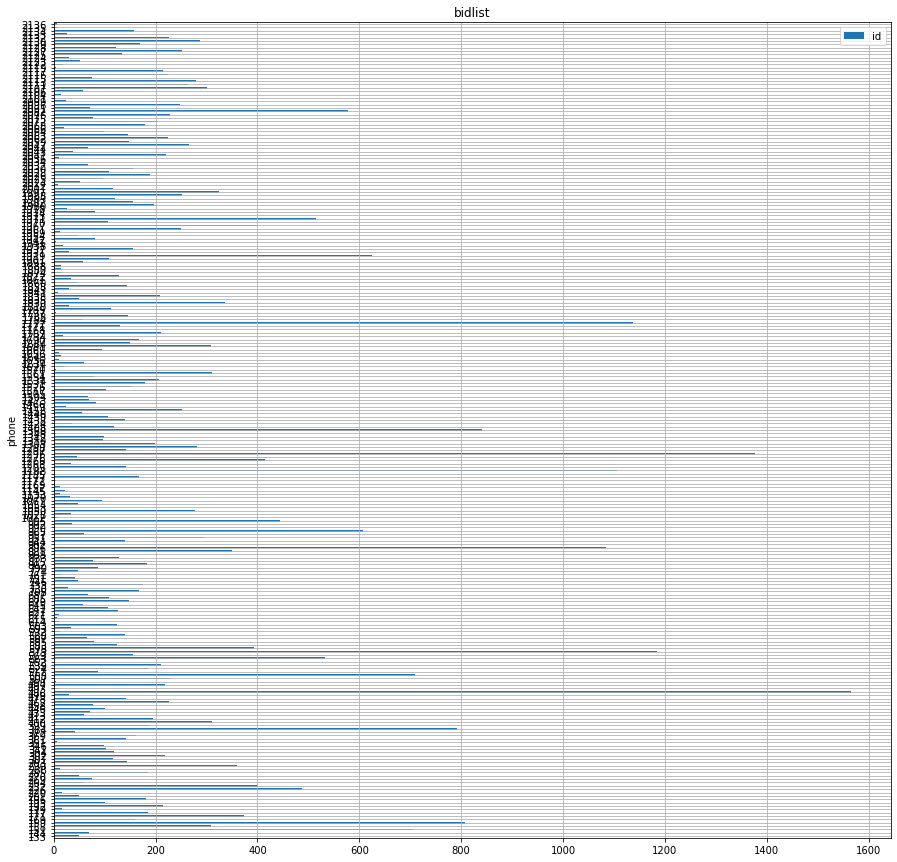

In [66]:
def plot_fun(df):
    df['day'] = df['date'].str.split().str[0]
    func = 'bidlist'
    graphic = df[df.func==func].groupby(['phone']).count().plot(
        y=[
            'id'
        ],
        kind='barh',
        title = func,
        figsize=(15,15),
        grid = True
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
plot_fun(df_b)

#### График по датам

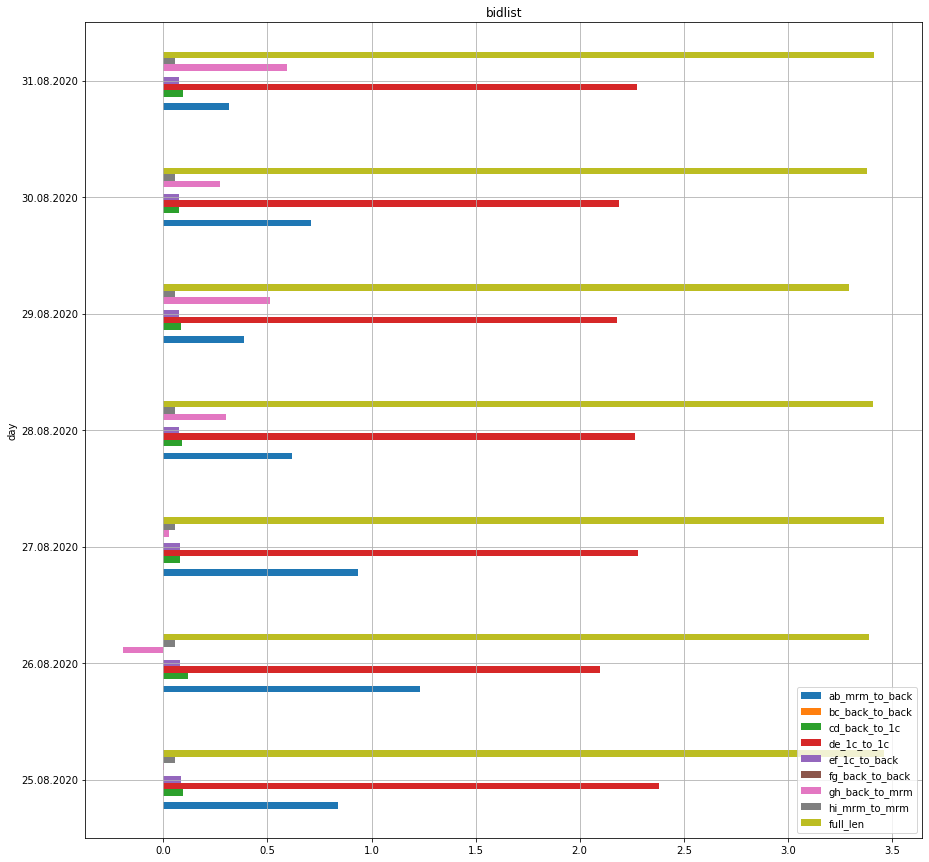

In [20]:
def plot_dates(df):
    
    df['day'] = df['date'].str.split().str[0]
    func = 'bidlist'
    #for func in df['func'].unique():
    #graphic = df[df.func==func].groupby('AppVersion').median().plot(
    #graphic = df.groupby('day').median().plot(        
    graphic = df[df.func==func].groupby('day').mean().plot(
        y=[
            'ab_mrm_to_back',
            'bc_back_to_back',
            'cd_back_to_1c',
            'de_1c_to_1c',
            'ef_1c_to_back',
            'fg_back_to_back',
            'gh_back_to_mrm',
            'hi_mrm_to_mrm',
            'full_len'
        ],
        kind='barh',
        title = func,
        #subplots=True,
        figsize=(15,15),
        grid = True
    )
    fig = graphic.get_figure()
    fig.savefig("myplot.png")
plot_dates(df_b)